In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# 数据的差分转换
def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

In [3]:
# 对预测的数据进行逆差分转换
def invert_difference(history,yhat,interval=1):
    return yhat+history[-interval]

In [4]:
# 将数据转换为监督学习集，移位后产生的NaN值补0
def timeseries_to_supervised(data,lag=1):
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1,lag+1)]
    columns.append(df)
    df=pd.concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df

In [5]:

# 将数据缩放到[-1,1]之间
def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

In [6]:

# 将预测值进行逆缩放，使用之前训练好的缩放器，x为一维数组，y为实数
def invert_scale(scaler,X,y):
    # 将X,y转换为一个list列表
    new_row=[x for x in X]+[y]
    # 将列表转换为数组
    array=np.array(new_row)
    # 将数组重构成一个形状为[1,2]的二维数组->[[10,12]]
    array=array.reshape(1,len(array))
    # 逆缩放输入的形状为[1,2]，输出形状也是如此
    invert=scaler.inverse_transform(array)
    # 只需要返回y值即可
    return invert[0,-1]

In [7]:

# 构建一个LSTM模型
def fit_lstm(train,batch_size,nb_epoch,neurons):
    # 将数据对中的x和y分开
    X,y=train[:,0:-1],train[:,-1]
    # 将2D数据拼接成3D数据，形状为[N*1*1]
    X=X.reshape(X.shape[0],1,X.shape[1])
 
    model=Sequential()
    model.add(LSTM(neurons,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(1))
 
    model.compile(loss='mean_squared_error',optimizer='adam')
    for i in range(nb_epoch):
        # shuffle是不混淆数据顺序
        his=model.fit(X,y,batch_size=batch_size,verbose=1,shuffle=False)
        # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
        model.reset_states()
    return model

In [8]:

# 开始单步预测
def forecast_lstm(model,batch_size,X):
    # 将形状为[1:]的，包含一个元素的一维数组X，转换形状为[1,1,1]的3D张量
    X=X.reshape(1,1,len(X))
    # 输出形状为1行一列的二维数组yhat
    yhat=model.predict(X,batch_size=batch_size)
    # 将yhat中的结果返回
    return yhat[0,0]

In [9]:
data = pd.read_excel('data.xlsx')
data.drop(['x1','x2','x3','x4','x5','x6','x7','x8','x9'],axis=1,inplace=True)
data['date']=pd.to_datetime(data['date'])
series=data.set_index(['date'],drop=True)

train_data = data.iloc[:120,:]
test_data = data.iloc[121:,:]

<Axes: xlabel='date'>

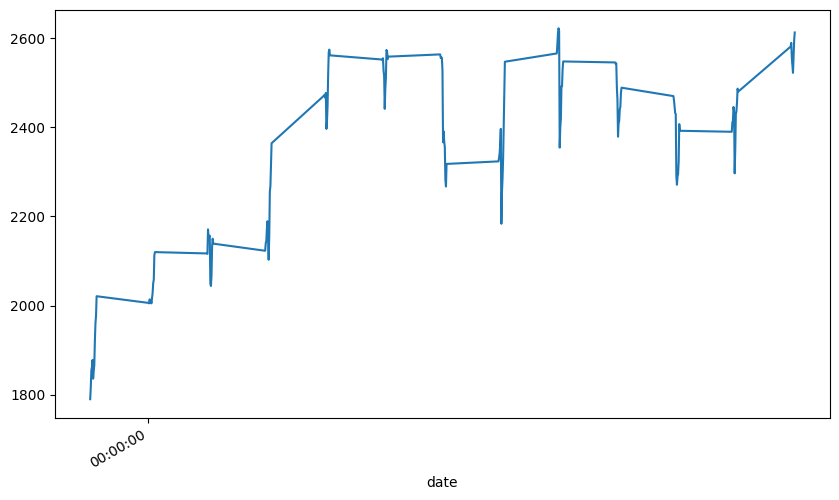

In [10]:
series = data.set_index(['date'])
plt.figure(figsize=(10, 6))
series['yt'].plot()

In [11]:
# 将原数据转换为二维数组形式，例如：
raw_value=series.values
#print(raw_value)
# 将数据进行差分转换
diff_value=difference(raw_value,1)
print(diff_value)
# 将序列形式的数据转换为监督学习集形式，例如[[10],[11],[12],[13]]
# 在此将其转换为监督学习集形式：[[0,10],[10,11],[11,12],[12,13]]，
# 即前一个数作为输入，后一个数作为对应的输出
supervised=timeseries_to_supervised(diff_value,1)
supervised_value=supervised.values

0                     [27.0]
1                     [38.0]
2                      [7.0]
3                     [16.0]
4                    [-42.0]
               ...          
147    [-15.559999999999945]
148      [-17.7800000000002]
149      [39.45000000000027]
150      [33.88999999999987]
151     [17.220000000000255]
Length: 152, dtype: object


In [12]:
# 将数据集分割为训练集和测试集，设置后1000个数据为测试集
testNum=50
train,test=supervised_value[:-testNum],supervised_value[-testNum:]
print(train)

[[0 array([27.])]
 [array([27.]) array([38.])]
 [array([38.]) array([7.])]
 [array([7.]) array([16.])]
 [array([16.]) array([-42.])]
 [array([-42.]) array([17.])]
 [array([17.]) array([13.])]
 [array([13.]) array([54.])]
 [array([54.]) array([40.])]
 [array([40.]) array([17.])]
 [array([17.]) array([44.])]
 [array([44.]) array([-15.])]
 [array([-15.]) array([-1.])]
 [array([-1.]) array([9.])]
 [array([9.]) array([-8.])]
 [array([-8.]) array([5.])]
 [array([5.]) array([-6.])]
 [array([-6.]) array([11.])]
 [array([11.]) array([12.])]
 [array([12.]) array([22.])]
 [array([22.]) array([8.])]
 [array([8.]) array([55.])]
 [array([55.]) array([7.])]
 [array([7.]) array([-3.])]
 [array([-3.]) array([-1.])]
 [array([-1.]) array([55.])]
 [array([55.]) array([-18.])]
 [array([-18.]) array([2.])]
 [array([2.]) array([2.])]
 [array([2.]) array([-107.])]
 [array([-107.]) array([-6.])]
 [array([-6.]) array([24.])]
 [array([24.]) array([65.])]
 [array([65.]) array([17.])]
 [array([17.]) array([-11.])]

In [13]:
# 将训练集和测试集都缩放到[-1,1]之间
scaler,train_scaled,test_scaled=scale(train,test)

In [14]:
# 构建一个LSTM模型并训练，样本数为1，训练次数为5，LSTM层神经元个数为4
lstm_model=fit_lstm(train_scaled,1,1,4)

102/102 [==============================] - 2s 2ms/step - loss: 0.1540


In [17]:

predictions=list()
for i in range(len(test_scaled)):
    # 将测试集拆分为X和y
    X,y=test[i,0:-1],test[i,-1]
    X = X.astype('float64')
    yhat=forecast_lstm(lstm_model,1,X)
    # 将预测值进行逆缩放
    yhat=invert_scale(scaler,X,yhat)
    # 对预测的y值进行逆差分
    yhat=invert_difference(raw_value,yhat,len(test_scaled)+1-i)
    # 存储正在预测的y值
    predictions.append(yhat)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')


1/1 [==============================] - 0s 21ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 20ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')


1/1 [==============================] - ETA: 0s

C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')


1/1 [==============================] - 0s 18ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 18ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 21ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 18ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 21ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 18ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 19ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - ETA: 0s

C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 20ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\3123899

1/1 [==============================] - 0s 21ms/step


C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_41540\312389984.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = X.astype('float64')


In [19]:
# 计算方差
rmse=mean_squared_error(raw_value[-testNum:],predictions)
print("Test RMSE:",rmse)
plt.plot(raw_value[-testNum:])
plt.plot(predictions)
plt.legend(['real','pred'])
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [153, 50]